In [1]:
from s3prl.downstream.mdd.dataset import L2ArcticDataset
from s3prl.downstream.augment_utils.add_noise import AddNoise
from IPython.display import Audio, display
import torch
import torchaudio
import numpy as np

2024-04-08 09:46:32.919754: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-08 09:46:32.953868: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 09:46:33.648187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [102]:
from h5py import File

with File("/home/xt0r3-user/cambridge/partii/dissertation/s3prl/data/A1.h5", "r") as f:
    ir = torch.tensor(f["data"]["impulse_response"][()])
    fs = f["metadata"]["sampling_rate"][()]

ir = ir / ir.norm(dim=-1)[:, :, None].expand(ir.shape)

In [103]:
ir.shape

torch.Size([4096, 64, 1024])

In [104]:
ir.norm(dim=-1)

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])

In [3]:
ir.shape

(4096, 64, 1024)

In [4]:
fs

32000

In [105]:
display(Audio(ir[1, 0], rate=16000))

In [7]:
ir[1, 0].shape[-1]

1024

In [12]:
ir[1, 0]

array([ 0.0000000e+00, -4.5273264e-08,  1.5094744e-07, ...,
       -1.4213913e-07, -3.6291890e-08, -0.0000000e+00], dtype=float32)

In [40]:
ir[:, 0].shape

(4096, 1024)

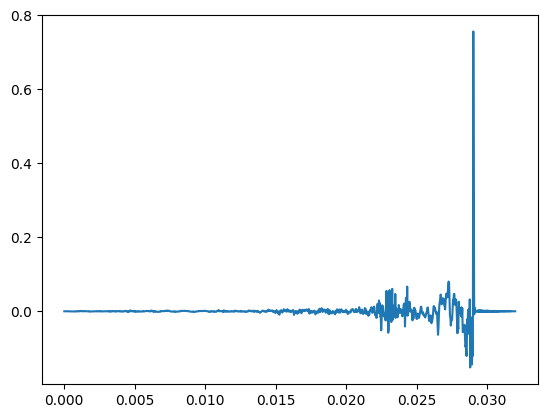

In [122]:
from matplotlib import pyplot as plt

def process(wav):
    maxi = wav.argmax()
    lo = max(0, maxi-50)
    hi=min(wav.shape[-1], maxi + 507)
    # lo=0
    # hi=1024
    return wav[lo:hi]

def plot(wav):
    plt.plot(np.linspace(0, len(wav) / fs, wav.shape[-1]), wav)

plot(ir[643, 32].flip(-1))

In [123]:
Audio(ir[643, 32].flip(-1), rate=32000)

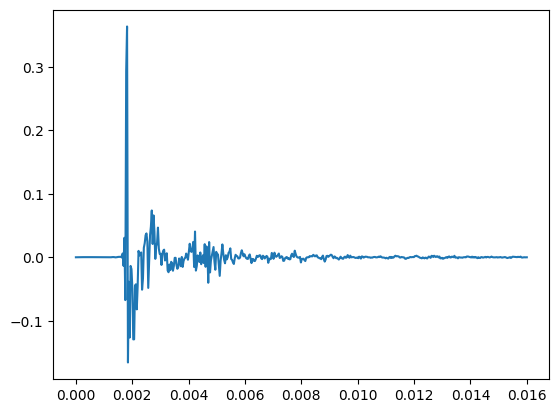

In [116]:
plot(torchaudio.functional.resample(ir[643, 0], orig_freq=32000, new_freq=16000))

In [16]:
dataset = L2ArcticDataset(
    "train",
    "/home/xt0r3-user/cambridge/partii/dissertation/s3prl/data/l2arctic_release_v5.0",
    "/home/xt0r3-user/cambridge/partii/dissertation/s3prl/s3prl/s3prl/downstream/mdd/data/",
)

Skipping malformatted TextGrid file: /home/xt0r3-user/cambridge/partii/dissertation/s3prl/data/l2arctic_release_v5.0/YDCK/annotation/arctic_a0272.TextGrid


In [17]:
def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()
    display(Audio(waveform, rate=sample_rate))


audio = [
    torchaudio.functional.resample(dataset[0][0], orig_freq=44100, new_freq=16000),
    torchaudio.functional.resample(dataset[1][0], orig_freq=44100, new_freq=16000),
]

In [107]:
Audio(torchaudio.functional.fftconvolve(audio[0], torchaudio.functional.resample(ir[1, 0].flip(-1), orig_freq=32000, new_freq=16000)), rate=16000)

In [121]:
Audio(torchaudio.functional.fftconvolve(audio[0], ir[523, 15].flip(-1)), rate=16000)

In [108]:
wav, sr = torchaudio.load('reverb.wav')

display(sr)

# wav = torchaudio.functional.resample(wav, sr, 16000)

wav = wav / np.linalg.norm(wav)

16000

In [111]:
wav.shape

torch.Size([2, 4757])

In [113]:
Audio(torchaudio.functional.fftconvolve(audio[0], wav[0]), rate=16000)

In [88]:
Audio(audio[0], rate=16000)

In [ ]:
sr

16000

In [72]:
display(Audio(wav, rate=sr))

In [ ]:
play_audio(audio[0], 16000)

In [ ]:
augmentation = AddNoise(
    prob=1.0,
    snr_low=0,
    snr_high=0.4,
    device="cpu",
    seed=1337,
)
audio = torch.nn.utils.rnn.pad_sequence(audio, batch_first=True)
lens = torch.tensor([len(audio[0]), len(audio[1])], dtype=torch.long)
aug_audio =     augmentation(
        audio,
        lens,
    )
play_audio(
    aug_audio[0],
    sample_rate=16000,
)

audio - aug_audio

tensor([[ 2.0554e-05, -5.1542e-05, -3.2218e-05,  ...,  2.9547e-04,
         -6.1925e-05,  8.1545e-05],
        [ 3.7022e-03, -5.9150e-03,  1.2691e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])